In [1]:
import json
import os
import label_transfer
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import slic
from skimage.util import img_as_float
from skimage.segmentation import mark_boundaries
from skimage import measure,draw 
import os
import cv2
from label_transfer import get_box
import label_transfer
from PIL import Image
import sys
sys.setrecursionlimit(1000000)

In [2]:
slide_path = '/home/bnc/tool/HistomicsML/yourproject/keras-yolo3/image/'
json_path =  '/home/bnc/tool/HistomicsML/yourproject/keras-yolo3/wsi_json/'
crop_path = '/home/bnc/tool/HistomicsML/yourproject/keras-yolo3/crop/'

In [3]:
list_slide = os.listdir(slide_path)
list_json = os.listdir(json_path)
print(list_slide)
print(list_json)

['49902003.png', '49984003.png', '50017007.png', '50017009.png', '50017010.png', '50033003.png', '50040003.png', '50045005.png', '50045006.png', '50049004.png', '50049007.png', '50996005.png', '50997003.png', '51008005.png', '51008007.png', '51008009.png', '51008010.png', '51008011.png', '51041004.png', '51049005.png', '51049006.png', '51053005.png', '51113003.png', '51124003.png', '51124004.png', '51133005.png', '51133010.png', '51136009.png', '51136010.png', '51163004.png', '51163005.png', '51231004.png', '51250003.png', '51270003.png', '51286009.png', '51291006.png', '51291010.png', '51301004.png', '51322003.png', '51387003.png', '51389005.png', '51389006.png', '51389007.png', '51389009.png', '51389010.png', '51400003.png', '51402005.png', '51405007.png', '51405008.png', '51405010.png', '51431003.png', '51446003.png', '51448004.png', '51448008.png', '51457003.png', '51457004.png', '52143006.png', '52166003.png', '52188003.png', '52195003.png', '52591002.png', '52604004.png', '526610

In [4]:
def get_mask(input_path,image_path,scale=None):
    info = label_transfer.openjson(input_path)
    ans = label_transfer.transform_cor(info,scale)
    image = img_as_float(io.imread(image_path))[...,0:3]
    h,w = image.shape[0:2]
    im = np.zeros((h,w), dtype="uint8")
    for mask in  ans:
        cv2.polylines(im, np.int32([mask]), 1, 1)
        cv2.fillPoly(im, np.int32([mask]), 1)
#     plt.imshow(im)
#     plt.show()
    return im

In [5]:
def help(x_min,y_min,x_max,y_max,n):
    center_x = (x_min + x_max)//2
    center_y = (y_min + y_max)//2
    res = []
    directions = [(-1,0),(1,0),(0,1),(0,-1)]  #(x,y)四个方向分别移动
    def dfs(x,y):
        if inArea(x,y):
            res.append([x-n/2,y-n/2,x+n/2,y+n/2])
        else:
            return
        for idx,idy in directions:
            new_x = x + idx*10
            new_y = y + idy*10
            temp = [new_x-n/2,new_y-n/2,new_x+n/2,new_y+n/2]
            if (temp not in res): # 保证不会找回原来的框
                dfs(new_x,new_y)
    def inArea(x,y):
        if(x_min<=x-n/2<=x+n/2<=x_max and y_min <= y-n/2 <= y+n/2 <= y_max):
            return True
        else:
            return False
    dfs(center_x,center_y)
    return res
# def meiju_box(json_path,scale=None):
#     info = label_transfer.openjson(json_path)
#     ans = label_transfer.transform_cor(info,scale)
#     boxes = label_transfer.get_box(ans)
#     res_box = []
#     for box in boxes:
#         x_min = int(box[0])
#         y_min = int(box[1])
#         x_max = int(box[2])
#         y_max = int(box[3])
#         for j in range(y_min,y_max,50):
#             for i in range(x_min,x_max,50):
#                 if  j+50 > y_max or i+50>x_max:
#                     continue
#                 temp = [i,j,i+50,j+50]
#                 res_box.append(temp)
#    return res_box

def dfs_box(json_path,scale=None):
    info = label_transfer.openjson(json_path)
    ans = label_transfer.transform_cor(info,scale)
    boxes = label_transfer.get_box(ans)
    res_box = []
    for box in boxes:
        x_min = int(box[0])
        y_min = int(box[1])
        x_max = int(box[2])
        y_max = int(box[3])
        temp = help(x_min,y_min,x_max,y_max,50)
        res_box.extend(temp)
    return res_box
    

In [6]:
def box_filter(json_path,image_path,scale=None):
    mask = get_mask(json_path,image_path,128)
    meiju = dfs_box(json_path,128)
    print(meiju)
#     print(meiju)
    image2 = cv2.imread(image_path)
    zuizhong = []
    for box in meiju:
        box[0] = int(box[0])
        box[1] = int(box[1])
        box[2] = int(box[2])
        box[3] = int(box[3])
        temp = mask[box[1]:box[3],box[0]:box[2]]
#         print("temp shape is {}".format(temp.shape))
        cur = np.sum(temp == 1)
#         print(temp.shape)
        if(cur == 2500):
            zuizhong.append(box)
    return zuizhong
        
    
#     image = img_as_float(io.imread(image_path))[...,0:3]
#     image2 = cv2.imread(image_path)
#     yuanshi = get_box(cor)
#     segments = slic(image, 150, sigma = 5)
#     inst_list = list(np.unique(segments))
#     mask = get_mask(json_path,image_path,128)
    
#     list_countours = []
#     for idx,inst_id in enumerate(inst_list):
#         inst_map = np.array(segments == inst_id).astype(int)
#         zuobiao = measure.find_contours(inst_map,0.5)
#         for zuo in  zuobiao:
#             list_countours.append(zuo)
#     boxes = []
#     for cor in list_countours:
#         cor = np.array(cor)
#         x_min = np.min(cor,axis=0)[0]
#         y_min = np.min(cor,axis=0)[1]
#         x_max = np.max(cor,axis=0)[0]
#         y_max = np.max(cor,axis=0)[1]
#         box = []
#         box.append(int(x_min))
#         box.append(int(y_min))
#         box.append(int(x_max))
#         box.append(int(y_max))
#         boxes.append(box)
#     print("shaiqian {}".format(len(boxes)))
#     new_boxes = []
#     for box in boxes:
#         box[0] = int(box[0])
#         box[1] = int(box[1])
#         box[2] = int(box[2])
#         box[3] = int(box[3])
#         daxiao = (box[2]-box[0]+1) * (box[3]-box[1]+1)
#         temp = mask[box[1]:box[3]+1,box[0]:box[2]+1]
#         cur = np.sum(temp == 1)
#         baifenbi = cur/daxiao
#         if baifenbi < 1:
#             continue
# #         image2 = cv2.rectangle(image2, (box[0], box[1]), (box[2], box[3]), (255, 0, 0),2)
# #         plt.imshow(image2)
# #         plt.show()
#         haha = []
#         haha.append(box[0])
#         haha.append(box[1])
#         haha.append(box[2])
#         haha.append(box[3])
#         new_boxes.append(haha)
#     print("shaihou {} ".format(len(new_boxes)))
#     return new_boxes
   
        
    
    

In [7]:
def get_slide_info(list_slide,list_json):
    res = []
    for slide in list_slide:
        slide_name = slide.split('.')[0]
        for json in list_json:
            json_name = json.split('.')[0]
            #print(json_name)
            if slide_name == json_name:
                img = {}
                img['slide_name'] = slide_name
                img['slide_path'] = os.path.join(slide_path,slide)
                img['json_path'] =  os.path.join(json_path,json)
                box_res = box_filter(os.path.join(json_path,json),os.path.join(slide_path,slide),128)
                img['boxes'] = box_res
                # img['boxes'] = label_transfer.get_info(os.path.join(json_path,json))
                res.append(img)
                print(slide_name+"=="+json_name)
    return res
                #cnt = cnt + 1
                #print(os.path.join(slide_path,slide)+" "+os.path.join(json_path,json))

def create_txt(res):
    classes = ["tumor"]
    list_file = open('train.txt','w')
    for data in res:
        list_file.write(data['slide_path'])
        for box in data['boxes']:
            list_file.write(" "+",".join([str(a)for a in box]) +','+'0')
        list_file.write('\r\n')
    list_file.close()

def main():
    res = get_slide_info(list_slide,list_json)
    for data in res:
        image = cv2.imread(data['slide_path'])
        slide = cv2.imread(data['slide_path'])
        slide = cv2.cvtColor(slide, cv2.COLOR_BGR2RGB)
        image_name = os.path.basename(data['slide_path']).split('.')[0]
        mask = get_mask(data['json_path'],data['slide_path'],128)
        boxes = data['boxes']
        for box in boxes:
            image = cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0),2)
            temp = slide[box[1]:box[3],box[0]:box[2],::]
            cv2.imwrite(crop_path+image_name+"_{}_{}.png".format(box[0],box[1]),temp)
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.subplot(1,2,2)
        plt.imshow(mask)
        plt.show()
    #create_txt(res)

[[297.0, 257.0, 347.0, 307.0], [287.0, 257.0, 337.0, 307.0], [277.0, 257.0, 327.0, 307.0], [267.0, 257.0, 317.0, 307.0], [257.0, 257.0, 307.0, 307.0], [247.0, 257.0, 297.0, 307.0], [237.0, 257.0, 287.0, 307.0], [227.0, 257.0, 277.0, 307.0], [217.0, 257.0, 267.0, 307.0], [207.0, 257.0, 257.0, 307.0], [197.0, 257.0, 247.0, 307.0], [187.0, 257.0, 237.0, 307.0], [177.0, 257.0, 227.0, 307.0], [167.0, 257.0, 217.0, 307.0], [167.0, 267.0, 217.0, 317.0], [177.0, 267.0, 227.0, 317.0], [187.0, 267.0, 237.0, 317.0], [197.0, 267.0, 247.0, 317.0], [207.0, 267.0, 257.0, 317.0], [217.0, 267.0, 267.0, 317.0], [227.0, 267.0, 277.0, 317.0], [237.0, 267.0, 287.0, 317.0], [247.0, 267.0, 297.0, 317.0], [257.0, 267.0, 307.0, 317.0], [267.0, 267.0, 317.0, 317.0], [277.0, 267.0, 327.0, 317.0], [287.0, 267.0, 337.0, 317.0], [297.0, 267.0, 347.0, 317.0], [307.0, 267.0, 357.0, 317.0], [317.0, 267.0, 367.0, 317.0], [327.0, 267.0, 377.0, 317.0], [337.0, 267.0, 387.0, 317.0], [347.0, 267.0, 397.0, 317.0], [357.0, 2

[[366.0, 353.0, 416.0, 403.0], [356.0, 353.0, 406.0, 403.0], [346.0, 353.0, 396.0, 403.0], [336.0, 353.0, 386.0, 403.0], [326.0, 353.0, 376.0, 403.0], [316.0, 353.0, 366.0, 403.0], [306.0, 353.0, 356.0, 403.0], [296.0, 353.0, 346.0, 403.0], [286.0, 353.0, 336.0, 403.0], [276.0, 353.0, 326.0, 403.0], [266.0, 353.0, 316.0, 403.0], [256.0, 353.0, 306.0, 403.0], [246.0, 353.0, 296.0, 403.0], [236.0, 353.0, 286.0, 403.0], [226.0, 353.0, 276.0, 403.0], [216.0, 353.0, 266.0, 403.0], [216.0, 363.0, 266.0, 413.0], [226.0, 363.0, 276.0, 413.0], [236.0, 363.0, 286.0, 413.0], [246.0, 363.0, 296.0, 413.0], [256.0, 363.0, 306.0, 413.0], [266.0, 363.0, 316.0, 413.0], [276.0, 363.0, 326.0, 413.0], [286.0, 363.0, 336.0, 413.0], [296.0, 363.0, 346.0, 413.0], [306.0, 363.0, 356.0, 413.0], [316.0, 363.0, 366.0, 413.0], [326.0, 363.0, 376.0, 413.0], [336.0, 363.0, 386.0, 413.0], [346.0, 363.0, 396.0, 413.0], [356.0, 363.0, 406.0, 413.0], [366.0, 363.0, 416.0, 413.0], [376.0, 363.0, 426.0, 413.0], [386.0, 3

[[478.0, 335.0, 528.0, 385.0], [468.0, 335.0, 518.0, 385.0], [458.0, 335.0, 508.0, 385.0], [448.0, 335.0, 498.0, 385.0], [438.0, 335.0, 488.0, 385.0], [438.0, 345.0, 488.0, 395.0], [448.0, 345.0, 498.0, 395.0], [458.0, 345.0, 508.0, 395.0], [468.0, 345.0, 518.0, 395.0], [478.0, 345.0, 528.0, 395.0], [488.0, 345.0, 538.0, 395.0], [498.0, 345.0, 548.0, 395.0], [508.0, 345.0, 558.0, 395.0], [518.0, 345.0, 568.0, 395.0], [518.0, 355.0, 568.0, 405.0], [508.0, 355.0, 558.0, 405.0], [498.0, 355.0, 548.0, 405.0], [488.0, 355.0, 538.0, 405.0], [478.0, 355.0, 528.0, 405.0], [468.0, 355.0, 518.0, 405.0], [458.0, 355.0, 508.0, 405.0], [448.0, 355.0, 498.0, 405.0], [438.0, 355.0, 488.0, 405.0], [518.0, 335.0, 568.0, 385.0], [508.0, 335.0, 558.0, 385.0], [498.0, 335.0, 548.0, 385.0], [488.0, 335.0, 538.0, 385.0], [488.0, 325.0, 538.0, 375.0], [478.0, 325.0, 528.0, 375.0], [468.0, 325.0, 518.0, 375.0], [458.0, 325.0, 508.0, 375.0], [448.0, 325.0, 498.0, 375.0], [438.0, 325.0, 488.0, 375.0], [438.0, 3

[[327.0, 375.0, 377.0, 425.0], [317.0, 375.0, 367.0, 425.0], [307.0, 375.0, 357.0, 425.0], [297.0, 375.0, 347.0, 425.0], [297.0, 385.0, 347.0, 435.0], [307.0, 385.0, 357.0, 435.0], [317.0, 385.0, 367.0, 435.0], [327.0, 385.0, 377.0, 435.0], [337.0, 385.0, 387.0, 435.0], [347.0, 385.0, 397.0, 435.0], [357.0, 385.0, 407.0, 435.0], [357.0, 395.0, 407.0, 445.0], [347.0, 395.0, 397.0, 445.0], [337.0, 395.0, 387.0, 445.0], [327.0, 395.0, 377.0, 445.0], [317.0, 395.0, 367.0, 445.0], [307.0, 395.0, 357.0, 445.0], [297.0, 395.0, 347.0, 445.0], [357.0, 375.0, 407.0, 425.0], [347.0, 375.0, 397.0, 425.0], [337.0, 375.0, 387.0, 425.0], [337.0, 365.0, 387.0, 415.0], [327.0, 365.0, 377.0, 415.0], [317.0, 365.0, 367.0, 415.0], [307.0, 365.0, 357.0, 415.0], [297.0, 365.0, 347.0, 415.0], [297.0, 355.0, 347.0, 405.0], [307.0, 355.0, 357.0, 405.0], [317.0, 355.0, 367.0, 405.0], [327.0, 355.0, 377.0, 405.0], [337.0, 355.0, 387.0, 405.0], [347.0, 355.0, 397.0, 405.0], [357.0, 355.0, 407.0, 405.0], [357.0, 3

[[342.0, 261.0, 392.0, 311.0], [332.0, 261.0, 382.0, 311.0], [322.0, 261.0, 372.0, 311.0], [312.0, 261.0, 362.0, 311.0], [302.0, 261.0, 352.0, 311.0], [292.0, 261.0, 342.0, 311.0], [282.0, 261.0, 332.0, 311.0], [272.0, 261.0, 322.0, 311.0], [262.0, 261.0, 312.0, 311.0], [252.0, 261.0, 302.0, 311.0], [242.0, 261.0, 292.0, 311.0], [232.0, 261.0, 282.0, 311.0], [222.0, 261.0, 272.0, 311.0], [212.0, 261.0, 262.0, 311.0], [202.0, 261.0, 252.0, 311.0], [192.0, 261.0, 242.0, 311.0], [182.0, 261.0, 232.0, 311.0], [172.0, 261.0, 222.0, 311.0], [162.0, 261.0, 212.0, 311.0], [152.0, 261.0, 202.0, 311.0], [142.0, 261.0, 192.0, 311.0], [132.0, 261.0, 182.0, 311.0], [122.0, 261.0, 172.0, 311.0], [112.0, 261.0, 162.0, 311.0], [102.0, 261.0, 152.0, 311.0], [102.0, 271.0, 152.0, 321.0], [112.0, 271.0, 162.0, 321.0], [122.0, 271.0, 172.0, 321.0], [132.0, 271.0, 182.0, 321.0], [142.0, 271.0, 192.0, 321.0], [152.0, 271.0, 202.0, 321.0], [162.0, 271.0, 212.0, 321.0], [172.0, 271.0, 222.0, 321.0], [182.0, 2

[[106.0, 89.0, 156.0, 139.0], [96.0, 89.0, 146.0, 139.0], [96.0, 99.0, 146.0, 149.0], [106.0, 99.0, 156.0, 149.0], [116.0, 99.0, 166.0, 149.0], [116.0, 89.0, 166.0, 139.0], [116.0, 79.0, 166.0, 129.0], [106.0, 79.0, 156.0, 129.0], [96.0, 79.0, 146.0, 129.0]]
51008010==51008010
[[655.0, 146.0, 705.0, 196.0]]
51008011==51008011
[[513.0, 551.0, 563.0, 601.0], [375.0, 543.0, 425.0, 593.0], [365.0, 543.0, 415.0, 593.0], [355.0, 543.0, 405.0, 593.0], [345.0, 543.0, 395.0, 593.0], [345.0, 553.0, 395.0, 603.0], [355.0, 553.0, 405.0, 603.0], [365.0, 553.0, 415.0, 603.0], [375.0, 553.0, 425.0, 603.0], [385.0, 553.0, 435.0, 603.0], [395.0, 553.0, 445.0, 603.0], [405.0, 553.0, 455.0, 603.0], [405.0, 563.0, 455.0, 613.0], [395.0, 563.0, 445.0, 613.0], [385.0, 563.0, 435.0, 613.0], [375.0, 563.0, 425.0, 613.0], [365.0, 563.0, 415.0, 613.0], [355.0, 563.0, 405.0, 613.0], [345.0, 563.0, 395.0, 613.0], [345.0, 573.0, 395.0, 623.0], [355.0, 573.0, 405.0, 623.0], [365.0, 573.0, 415.0, 623.0], [375.0, 573

[[597.0, 318.0, 647.0, 368.0], [587.0, 318.0, 637.0, 368.0], [577.0, 318.0, 627.0, 368.0], [567.0, 318.0, 617.0, 368.0], [557.0, 318.0, 607.0, 368.0], [547.0, 318.0, 597.0, 368.0], [537.0, 318.0, 587.0, 368.0], [527.0, 318.0, 577.0, 368.0], [517.0, 318.0, 567.0, 368.0], [507.0, 318.0, 557.0, 368.0], [497.0, 318.0, 547.0, 368.0], [487.0, 318.0, 537.0, 368.0], [477.0, 318.0, 527.0, 368.0], [467.0, 318.0, 517.0, 368.0], [467.0, 328.0, 517.0, 378.0], [477.0, 328.0, 527.0, 378.0], [487.0, 328.0, 537.0, 378.0], [497.0, 328.0, 547.0, 378.0], [507.0, 328.0, 557.0, 378.0], [517.0, 328.0, 567.0, 378.0], [527.0, 328.0, 577.0, 378.0], [537.0, 328.0, 587.0, 378.0], [547.0, 328.0, 597.0, 378.0], [557.0, 328.0, 607.0, 378.0], [567.0, 328.0, 617.0, 378.0], [577.0, 328.0, 627.0, 378.0], [587.0, 328.0, 637.0, 378.0], [597.0, 328.0, 647.0, 378.0], [607.0, 328.0, 657.0, 378.0], [617.0, 328.0, 667.0, 378.0], [627.0, 328.0, 677.0, 378.0], [637.0, 328.0, 687.0, 378.0], [647.0, 328.0, 697.0, 378.0], [657.0, 3

[[258.0, 187.0, 308.0, 237.0], [248.0, 187.0, 298.0, 237.0], [238.0, 187.0, 288.0, 237.0], [228.0, 187.0, 278.0, 237.0], [218.0, 187.0, 268.0, 237.0], [208.0, 187.0, 258.0, 237.0], [198.0, 187.0, 248.0, 237.0], [188.0, 187.0, 238.0, 237.0], [178.0, 187.0, 228.0, 237.0], [168.0, 187.0, 218.0, 237.0], [158.0, 187.0, 208.0, 237.0], [148.0, 187.0, 198.0, 237.0], [138.0, 187.0, 188.0, 237.0], [128.0, 187.0, 178.0, 237.0], [128.0, 197.0, 178.0, 247.0], [138.0, 197.0, 188.0, 247.0], [148.0, 197.0, 198.0, 247.0], [158.0, 197.0, 208.0, 247.0], [168.0, 197.0, 218.0, 247.0], [178.0, 197.0, 228.0, 247.0], [188.0, 197.0, 238.0, 247.0], [198.0, 197.0, 248.0, 247.0], [208.0, 197.0, 258.0, 247.0], [218.0, 197.0, 268.0, 247.0], [228.0, 197.0, 278.0, 247.0], [238.0, 197.0, 288.0, 247.0], [248.0, 197.0, 298.0, 247.0], [258.0, 197.0, 308.0, 247.0], [268.0, 197.0, 318.0, 247.0], [278.0, 197.0, 328.0, 247.0], [288.0, 197.0, 338.0, 247.0], [298.0, 197.0, 348.0, 247.0], [308.0, 197.0, 358.0, 247.0], [318.0, 1

[[422.0, 107.0, 472.0, 157.0]]
51136010==51136010
[[259.0, 197.0, 309.0, 247.0], [249.0, 197.0, 299.0, 247.0], [239.0, 197.0, 289.0, 247.0], [229.0, 197.0, 279.0, 247.0], [219.0, 197.0, 269.0, 247.0], [209.0, 197.0, 259.0, 247.0], [199.0, 197.0, 249.0, 247.0], [189.0, 197.0, 239.0, 247.0], [179.0, 197.0, 229.0, 247.0], [169.0, 197.0, 219.0, 247.0], [169.0, 207.0, 219.0, 257.0], [179.0, 207.0, 229.0, 257.0], [189.0, 207.0, 239.0, 257.0], [199.0, 207.0, 249.0, 257.0], [209.0, 207.0, 259.0, 257.0], [219.0, 207.0, 269.0, 257.0], [229.0, 207.0, 279.0, 257.0], [239.0, 207.0, 289.0, 257.0], [249.0, 207.0, 299.0, 257.0], [259.0, 207.0, 309.0, 257.0], [269.0, 207.0, 319.0, 257.0], [279.0, 207.0, 329.0, 257.0], [289.0, 207.0, 339.0, 257.0], [299.0, 207.0, 349.0, 257.0], [309.0, 207.0, 359.0, 257.0], [319.0, 207.0, 369.0, 257.0], [329.0, 207.0, 379.0, 257.0], [339.0, 207.0, 389.0, 257.0], [349.0, 207.0, 399.0, 257.0], [349.0, 217.0, 399.0, 267.0], [339.0, 217.0, 389.0, 267.0], [329.0, 217.0, 379.

51270003==51270003
[[259.0, 350.0, 309.0, 400.0], [249.0, 350.0, 299.0, 400.0], [249.0, 360.0, 299.0, 410.0], [259.0, 360.0, 309.0, 410.0], [269.0, 360.0, 319.0, 410.0], [269.0, 350.0, 319.0, 400.0], [269.0, 340.0, 319.0, 390.0], [259.0, 340.0, 309.0, 390.0], [249.0, 340.0, 299.0, 390.0]]
51286009==51286009
[[551.0, 167.0, 601.0, 217.0], [541.0, 167.0, 591.0, 217.0], [531.0, 167.0, 581.0, 217.0], [521.0, 167.0, 571.0, 217.0], [511.0, 167.0, 561.0, 217.0], [501.0, 167.0, 551.0, 217.0], [491.0, 167.0, 541.0, 217.0], [481.0, 167.0, 531.0, 217.0], [471.0, 167.0, 521.0, 217.0], [461.0, 167.0, 511.0, 217.0], [451.0, 167.0, 501.0, 217.0], [441.0, 167.0, 491.0, 217.0], [431.0, 167.0, 481.0, 217.0], [421.0, 167.0, 471.0, 217.0], [411.0, 167.0, 461.0, 217.0], [401.0, 167.0, 451.0, 217.0], [391.0, 167.0, 441.0, 217.0], [381.0, 167.0, 431.0, 217.0], [371.0, 167.0, 421.0, 217.0], [361.0, 167.0, 411.0, 217.0], [361.0, 177.0, 411.0, 227.0], [371.0, 177.0, 421.0, 227.0], [381.0, 177.0, 431.0, 227.0], 

51291006==51291006
[[119.0, 267.0, 169.0, 317.0], [119.0, 277.0, 169.0, 327.0], [119.0, 287.0, 169.0, 337.0], [119.0, 257.0, 169.0, 307.0], [119.0, 247.0, 169.0, 297.0]]
51291010==51291010
[]
51301004==51301004
[[80.0, 165.0, 130.0, 215.0], [70.0, 165.0, 120.0, 215.0], [60.0, 165.0, 110.0, 215.0], [50.0, 165.0, 100.0, 215.0], [40.0, 165.0, 90.0, 215.0], [40.0, 175.0, 90.0, 225.0], [50.0, 175.0, 100.0, 225.0], [60.0, 175.0, 110.0, 225.0], [70.0, 175.0, 120.0, 225.0], [80.0, 175.0, 130.0, 225.0], [90.0, 175.0, 140.0, 225.0], [100.0, 175.0, 150.0, 225.0], [110.0, 175.0, 160.0, 225.0], [120.0, 175.0, 170.0, 225.0], [120.0, 185.0, 170.0, 235.0], [110.0, 185.0, 160.0, 235.0], [100.0, 185.0, 150.0, 235.0], [90.0, 185.0, 140.0, 235.0], [80.0, 185.0, 130.0, 235.0], [70.0, 185.0, 120.0, 235.0], [60.0, 185.0, 110.0, 235.0], [50.0, 185.0, 100.0, 235.0], [40.0, 185.0, 90.0, 235.0], [40.0, 195.0, 90.0, 245.0], [50.0, 195.0, 100.0, 245.0], [60.0, 195.0, 110.0, 245.0], [70.0, 195.0, 120.0, 245.0], [80

[[390.0, 119.0, 440.0, 169.0], [380.0, 119.0, 430.0, 169.0], [380.0, 129.0, 430.0, 179.0], [390.0, 129.0, 440.0, 179.0], [400.0, 129.0, 450.0, 179.0], [400.0, 139.0, 450.0, 189.0], [390.0, 139.0, 440.0, 189.0], [380.0, 139.0, 430.0, 189.0], [380.0, 149.0, 430.0, 199.0], [390.0, 149.0, 440.0, 199.0], [400.0, 149.0, 450.0, 199.0], [400.0, 159.0, 450.0, 209.0], [390.0, 159.0, 440.0, 209.0], [380.0, 159.0, 430.0, 209.0], [400.0, 119.0, 450.0, 169.0], [400.0, 109.0, 450.0, 159.0], [390.0, 109.0, 440.0, 159.0], [380.0, 109.0, 430.0, 159.0], [380.0, 99.0, 430.0, 149.0], [390.0, 99.0, 440.0, 149.0], [400.0, 99.0, 450.0, 149.0], [400.0, 89.0, 450.0, 139.0], [390.0, 89.0, 440.0, 139.0], [380.0, 89.0, 430.0, 139.0], [380.0, 79.0, 430.0, 129.0], [390.0, 79.0, 440.0, 129.0], [400.0, 79.0, 450.0, 129.0], [152.0, 168.0, 202.0, 218.0], [142.0, 168.0, 192.0, 218.0], [132.0, 168.0, 182.0, 218.0], [122.0, 168.0, 172.0, 218.0], [112.0, 168.0, 162.0, 218.0], [102.0, 168.0, 152.0, 218.0], [92.0, 168.0, 142.

[[168.0, 257.0, 218.0, 307.0], [158.0, 257.0, 208.0, 307.0], [148.0, 257.0, 198.0, 307.0], [148.0, 267.0, 198.0, 317.0], [158.0, 267.0, 208.0, 317.0], [168.0, 267.0, 218.0, 317.0], [178.0, 267.0, 228.0, 317.0], [188.0, 267.0, 238.0, 317.0], [188.0, 257.0, 238.0, 307.0], [178.0, 257.0, 228.0, 307.0], [178.0, 247.0, 228.0, 297.0], [168.0, 247.0, 218.0, 297.0], [158.0, 247.0, 208.0, 297.0], [148.0, 247.0, 198.0, 297.0], [188.0, 247.0, 238.0, 297.0]]
51448008==51448008
[[307.0, 310.0, 357.0, 360.0], [297.0, 310.0, 347.0, 360.0], [287.0, 310.0, 337.0, 360.0], [277.0, 310.0, 327.0, 360.0], [267.0, 310.0, 317.0, 360.0], [257.0, 310.0, 307.0, 360.0], [247.0, 310.0, 297.0, 360.0], [237.0, 310.0, 287.0, 360.0], [227.0, 310.0, 277.0, 360.0], [217.0, 310.0, 267.0, 360.0], [207.0, 310.0, 257.0, 360.0], [197.0, 310.0, 247.0, 360.0], [187.0, 310.0, 237.0, 360.0], [177.0, 310.0, 227.0, 360.0], [167.0, 310.0, 217.0, 360.0], [157.0, 310.0, 207.0, 360.0], [147.0, 310.0, 197.0, 360.0], [147.0, 320.0, 197.

[[275.0, 221.0, 325.0, 271.0], [265.0, 221.0, 315.0, 271.0], [255.0, 221.0, 305.0, 271.0], [245.0, 221.0, 295.0, 271.0], [235.0, 221.0, 285.0, 271.0], [225.0, 221.0, 275.0, 271.0], [215.0, 221.0, 265.0, 271.0], [205.0, 221.0, 255.0, 271.0], [195.0, 221.0, 245.0, 271.0], [185.0, 221.0, 235.0, 271.0], [175.0, 221.0, 225.0, 271.0], [165.0, 221.0, 215.0, 271.0], [155.0, 221.0, 205.0, 271.0], [145.0, 221.0, 195.0, 271.0], [135.0, 221.0, 185.0, 271.0], [125.0, 221.0, 175.0, 271.0], [125.0, 231.0, 175.0, 281.0], [135.0, 231.0, 185.0, 281.0], [145.0, 231.0, 195.0, 281.0], [155.0, 231.0, 205.0, 281.0], [165.0, 231.0, 215.0, 281.0], [175.0, 231.0, 225.0, 281.0], [185.0, 231.0, 235.0, 281.0], [195.0, 231.0, 245.0, 281.0], [205.0, 231.0, 255.0, 281.0], [215.0, 231.0, 265.0, 281.0], [225.0, 231.0, 275.0, 281.0], [235.0, 231.0, 285.0, 281.0], [245.0, 231.0, 295.0, 281.0], [255.0, 231.0, 305.0, 281.0], [265.0, 231.0, 315.0, 281.0], [275.0, 231.0, 325.0, 281.0], [285.0, 231.0, 335.0, 281.0], [295.0, 2

[[414.0, 188.0, 464.0, 238.0], [404.0, 188.0, 454.0, 238.0], [394.0, 188.0, 444.0, 238.0], [384.0, 188.0, 434.0, 238.0], [374.0, 188.0, 424.0, 238.0], [364.0, 188.0, 414.0, 238.0], [354.0, 188.0, 404.0, 238.0], [344.0, 188.0, 394.0, 238.0], [334.0, 188.0, 384.0, 238.0], [324.0, 188.0, 374.0, 238.0], [314.0, 188.0, 364.0, 238.0], [304.0, 188.0, 354.0, 238.0], [294.0, 188.0, 344.0, 238.0], [284.0, 188.0, 334.0, 238.0], [274.0, 188.0, 324.0, 238.0], [264.0, 188.0, 314.0, 238.0], [254.0, 188.0, 304.0, 238.0], [244.0, 188.0, 294.0, 238.0], [234.0, 188.0, 284.0, 238.0], [224.0, 188.0, 274.0, 238.0], [224.0, 198.0, 274.0, 248.0], [234.0, 198.0, 284.0, 248.0], [244.0, 198.0, 294.0, 248.0], [254.0, 198.0, 304.0, 248.0], [264.0, 198.0, 314.0, 248.0], [274.0, 198.0, 324.0, 248.0], [284.0, 198.0, 334.0, 248.0], [294.0, 198.0, 344.0, 248.0], [304.0, 198.0, 354.0, 248.0], [314.0, 198.0, 364.0, 248.0], [324.0, 198.0, 374.0, 248.0], [334.0, 198.0, 384.0, 248.0], [344.0, 198.0, 394.0, 248.0], [354.0, 1

[[286.0, 290.0, 336.0, 340.0], [276.0, 290.0, 326.0, 340.0], [266.0, 290.0, 316.0, 340.0], [266.0, 300.0, 316.0, 350.0], [276.0, 300.0, 326.0, 350.0], [286.0, 300.0, 336.0, 350.0], [296.0, 300.0, 346.0, 350.0], [306.0, 300.0, 356.0, 350.0], [306.0, 310.0, 356.0, 360.0], [296.0, 310.0, 346.0, 360.0], [286.0, 310.0, 336.0, 360.0], [276.0, 310.0, 326.0, 360.0], [266.0, 310.0, 316.0, 360.0], [306.0, 290.0, 356.0, 340.0], [296.0, 290.0, 346.0, 340.0], [296.0, 280.0, 346.0, 330.0], [286.0, 280.0, 336.0, 330.0], [276.0, 280.0, 326.0, 330.0], [266.0, 280.0, 316.0, 330.0], [266.0, 270.0, 316.0, 320.0], [276.0, 270.0, 326.0, 320.0], [286.0, 270.0, 336.0, 320.0], [296.0, 270.0, 346.0, 320.0], [306.0, 270.0, 356.0, 320.0], [306.0, 280.0, 356.0, 330.0], [270.0, 547.0, 320.0, 597.0], [260.0, 547.0, 310.0, 597.0], [250.0, 547.0, 300.0, 597.0], [250.0, 557.0, 300.0, 607.0], [260.0, 557.0, 310.0, 607.0], [270.0, 557.0, 320.0, 607.0], [280.0, 557.0, 330.0, 607.0], [290.0, 557.0, 340.0, 607.0], [290.0, 5

52672004==52672004
[[363.0, 271.0, 413.0, 321.0], [353.0, 271.0, 403.0, 321.0], [343.0, 271.0, 393.0, 321.0], [333.0, 271.0, 383.0, 321.0], [323.0, 271.0, 373.0, 321.0], [323.0, 281.0, 373.0, 331.0], [333.0, 281.0, 383.0, 331.0], [343.0, 281.0, 393.0, 331.0], [353.0, 281.0, 403.0, 331.0], [363.0, 281.0, 413.0, 331.0], [373.0, 281.0, 423.0, 331.0], [383.0, 281.0, 433.0, 331.0], [393.0, 281.0, 443.0, 331.0], [403.0, 281.0, 453.0, 331.0], [403.0, 291.0, 453.0, 341.0], [393.0, 291.0, 443.0, 341.0], [383.0, 291.0, 433.0, 341.0], [373.0, 291.0, 423.0, 341.0], [363.0, 291.0, 413.0, 341.0], [353.0, 291.0, 403.0, 341.0], [343.0, 291.0, 393.0, 341.0], [333.0, 291.0, 383.0, 341.0], [323.0, 291.0, 373.0, 341.0], [323.0, 301.0, 373.0, 351.0], [333.0, 301.0, 383.0, 351.0], [343.0, 301.0, 393.0, 351.0], [353.0, 301.0, 403.0, 351.0], [363.0, 301.0, 413.0, 351.0], [373.0, 301.0, 423.0, 351.0], [383.0, 301.0, 433.0, 351.0], [393.0, 301.0, 443.0, 351.0], [403.0, 301.0, 453.0, 351.0], [403.0, 311.0, 453.0

[[296.0, 357.0, 346.0, 407.0], [286.0, 357.0, 336.0, 407.0], [276.0, 357.0, 326.0, 407.0], [266.0, 357.0, 316.0, 407.0], [256.0, 357.0, 306.0, 407.0], [246.0, 357.0, 296.0, 407.0], [236.0, 357.0, 286.0, 407.0], [226.0, 357.0, 276.0, 407.0], [216.0, 357.0, 266.0, 407.0], [206.0, 357.0, 256.0, 407.0], [196.0, 357.0, 246.0, 407.0], [186.0, 357.0, 236.0, 407.0], [176.0, 357.0, 226.0, 407.0], [166.0, 357.0, 216.0, 407.0], [156.0, 357.0, 206.0, 407.0], [146.0, 357.0, 196.0, 407.0], [136.0, 357.0, 186.0, 407.0], [126.0, 357.0, 176.0, 407.0], [116.0, 357.0, 166.0, 407.0], [106.0, 357.0, 156.0, 407.0], [96.0, 357.0, 146.0, 407.0], [86.0, 357.0, 136.0, 407.0], [76.0, 357.0, 126.0, 407.0], [66.0, 357.0, 116.0, 407.0], [66.0, 367.0, 116.0, 417.0], [76.0, 367.0, 126.0, 417.0], [86.0, 367.0, 136.0, 417.0], [96.0, 367.0, 146.0, 417.0], [106.0, 367.0, 156.0, 417.0], [116.0, 367.0, 166.0, 417.0], [126.0, 367.0, 176.0, 417.0], [136.0, 367.0, 186.0, 417.0], [146.0, 367.0, 196.0, 417.0], [156.0, 367.0, 20

[[373.0, 303.0, 423.0, 353.0], [363.0, 303.0, 413.0, 353.0], [353.0, 303.0, 403.0, 353.0], [343.0, 303.0, 393.0, 353.0], [333.0, 303.0, 383.0, 353.0], [323.0, 303.0, 373.0, 353.0], [313.0, 303.0, 363.0, 353.0], [303.0, 303.0, 353.0, 353.0], [293.0, 303.0, 343.0, 353.0], [283.0, 303.0, 333.0, 353.0], [273.0, 303.0, 323.0, 353.0], [263.0, 303.0, 313.0, 353.0], [253.0, 303.0, 303.0, 353.0], [243.0, 303.0, 293.0, 353.0], [233.0, 303.0, 283.0, 353.0], [223.0, 303.0, 273.0, 353.0], [223.0, 313.0, 273.0, 363.0], [233.0, 313.0, 283.0, 363.0], [243.0, 313.0, 293.0, 363.0], [253.0, 313.0, 303.0, 363.0], [263.0, 313.0, 313.0, 363.0], [273.0, 313.0, 323.0, 363.0], [283.0, 313.0, 333.0, 363.0], [293.0, 313.0, 343.0, 363.0], [303.0, 313.0, 353.0, 363.0], [313.0, 313.0, 363.0, 363.0], [323.0, 313.0, 373.0, 363.0], [333.0, 313.0, 383.0, 363.0], [343.0, 313.0, 393.0, 363.0], [353.0, 313.0, 403.0, 363.0], [363.0, 313.0, 413.0, 363.0], [373.0, 313.0, 423.0, 363.0], [383.0, 313.0, 433.0, 363.0], [393.0, 3

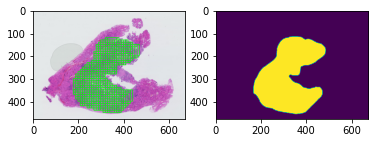

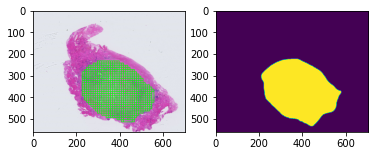

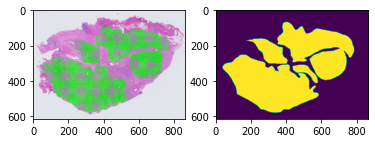

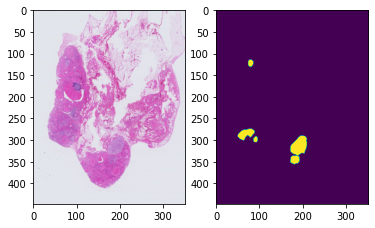

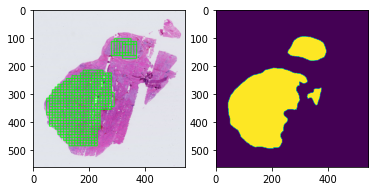

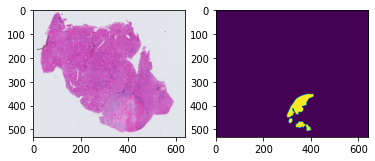

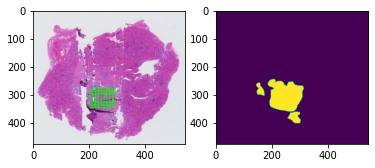

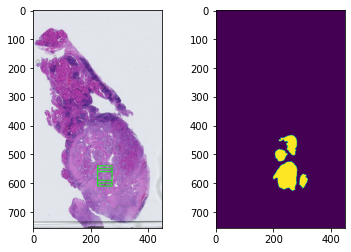

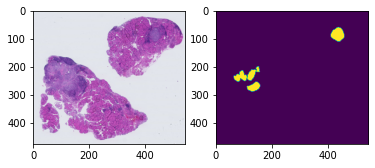

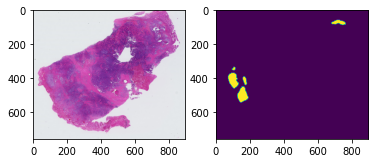

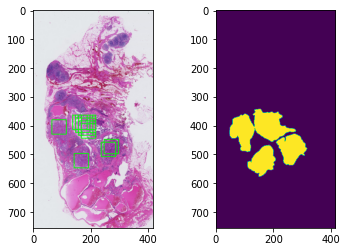

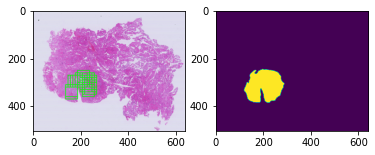

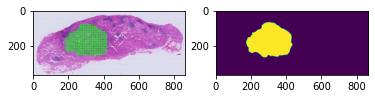

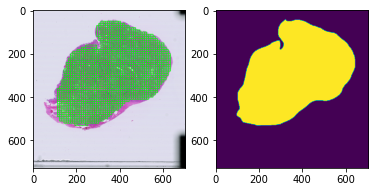

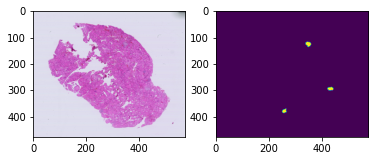

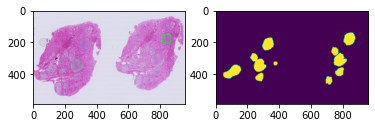

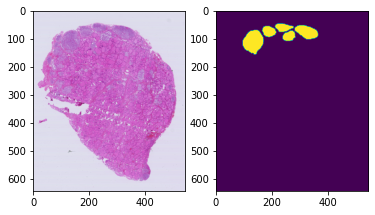

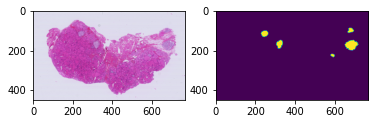

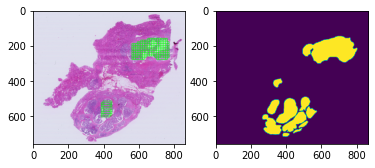

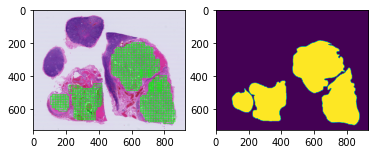

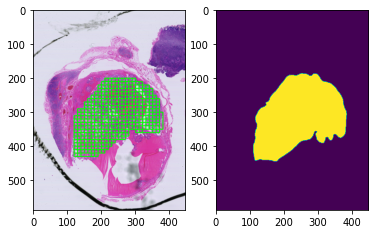

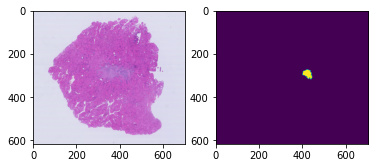

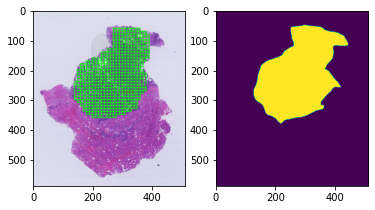

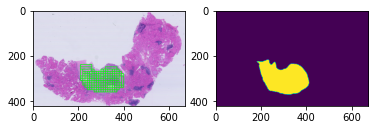

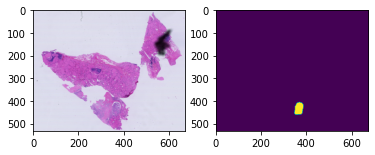

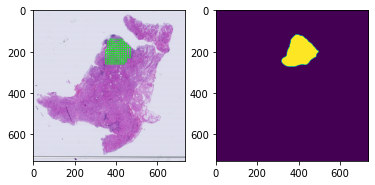

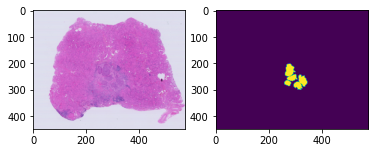

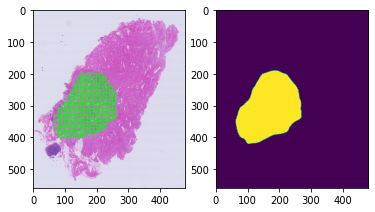

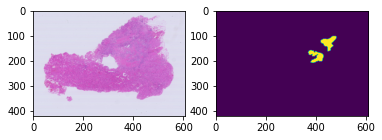

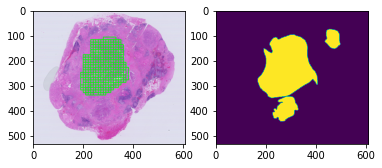

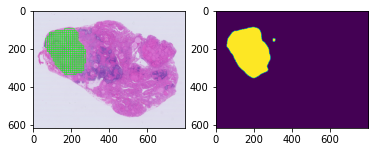

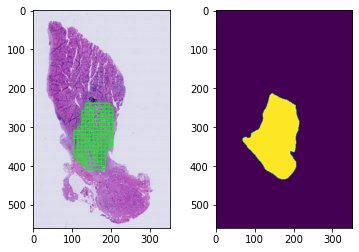

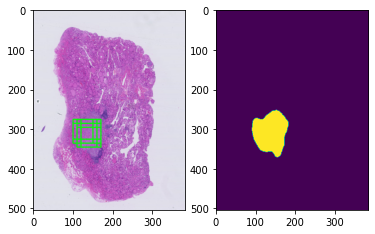

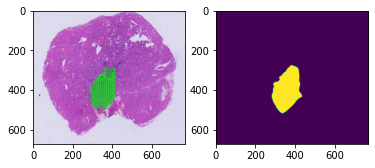

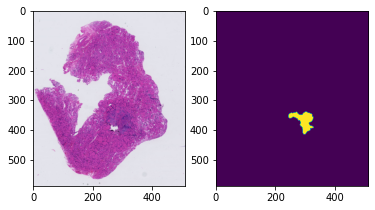

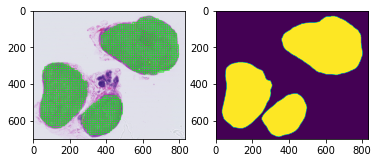

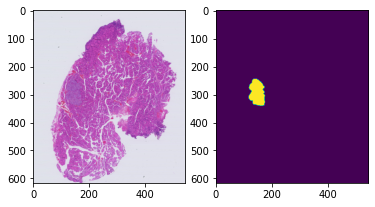

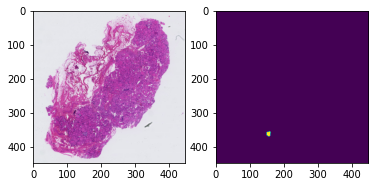

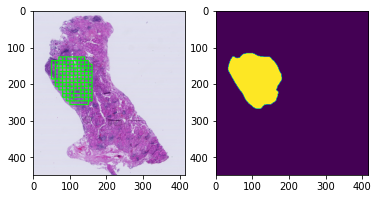

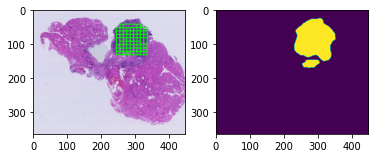

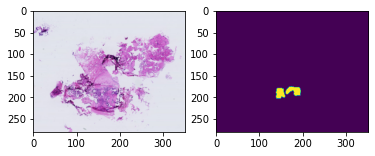

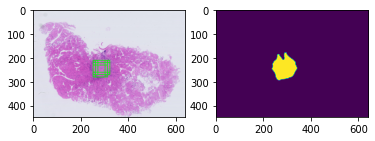

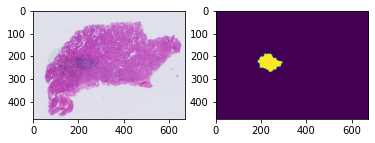

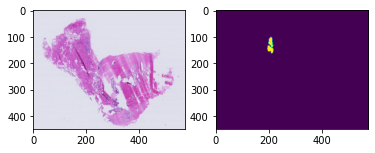

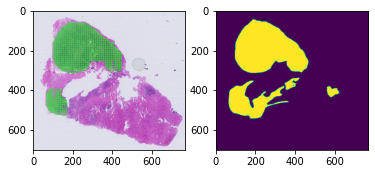

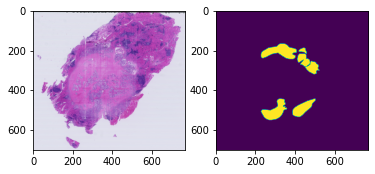

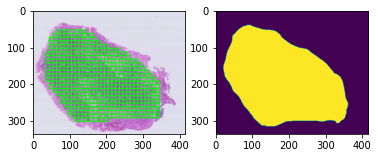

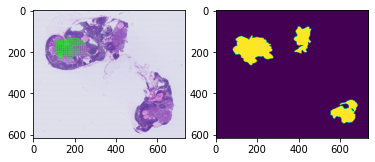

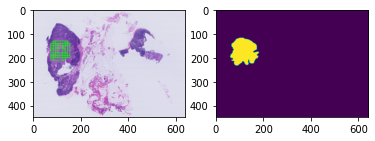

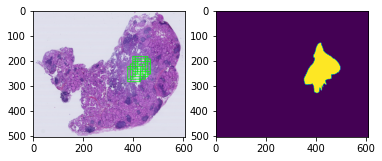

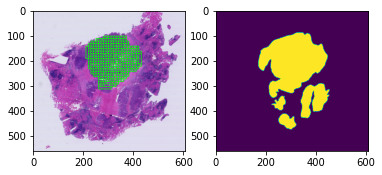

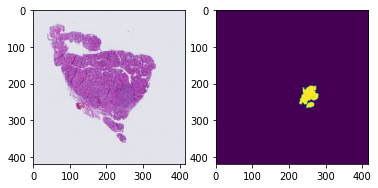

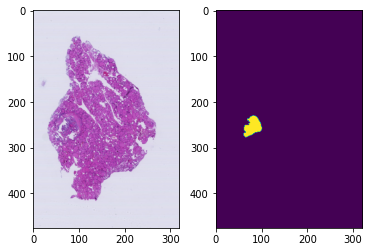

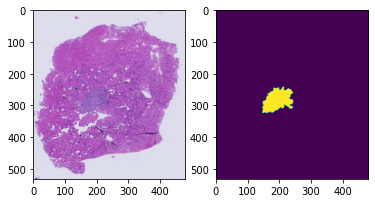

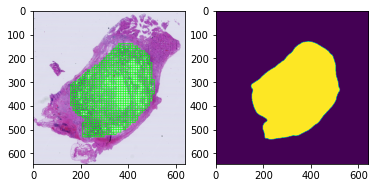

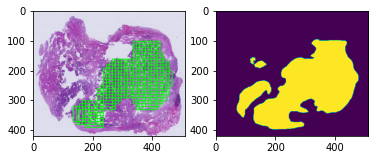

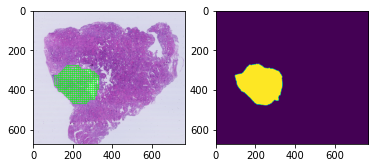

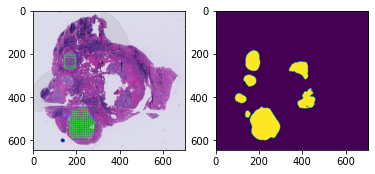

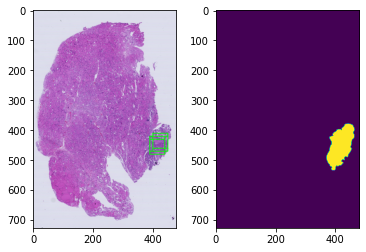

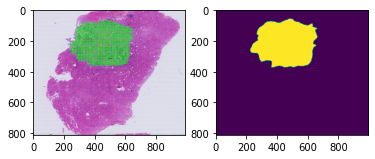

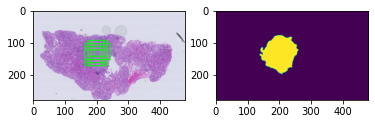

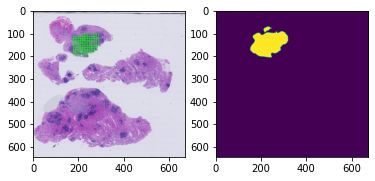

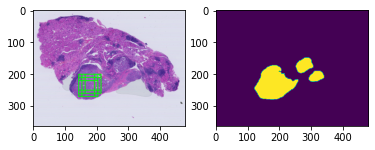

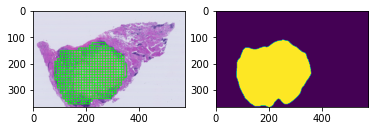

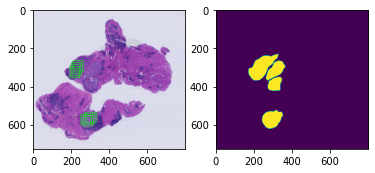

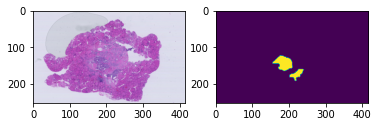

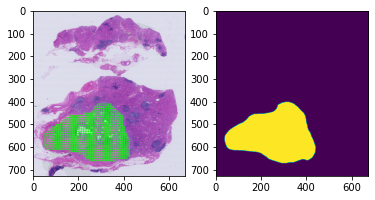

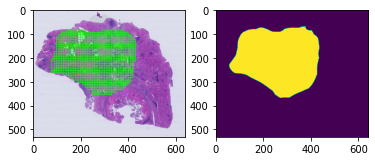

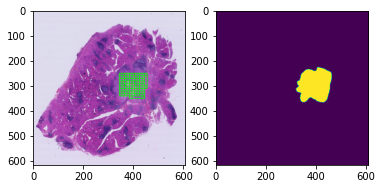

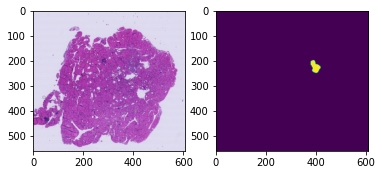

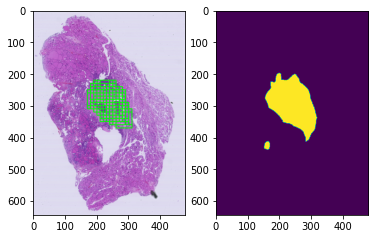

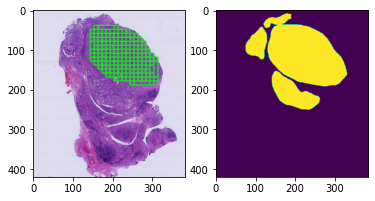

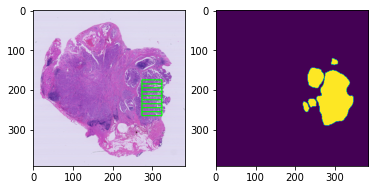

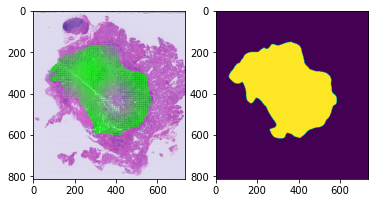

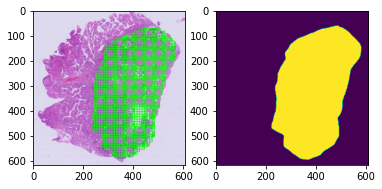

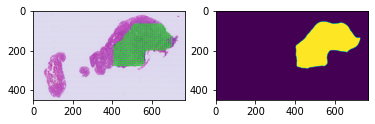

In [8]:
if __name__ == "__main__":
    main()